# Compare average acceleration between groups for several diseases

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

In [2]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer'
data_path2 = '/scratch/c.c21013066/data/ukbiobank/sample/withGP/noOsteo'

In [3]:
# 4 cases: (raw, residual) * (all, comorbid removed)
dfs_res = pd.read_csv(f'{data_path}/unmatched_all_HCnoOsteo.csv',
                      index_col=0)
dfs_res_BMI = pd.read_csv(f'{data_path}/unmatched_all_residual_BMI_HCnoOsteo_intercept.csv',
                      index_col=0)
dfs_res_noDepPD = pd.read_csv(f'{data_path}/unmatched_all_HCnoOsteo_NoDepressedNoPD.csv',
                      index_col=0)
dfs_res_noDepPD_BMI = pd.read_csv(f'{data_path}/unmatched_all_NoDepressedNoPD_residual_BMI_HCnoOsteo_intercept.csv',
                      index_col=0)
dfs = [dfs_res,dfs_res_BMI,dfs_res_noDepPD,dfs_res_noDepPD_BMI]
hc_bmi = pd.read_csv(f'{data_path}/HCnoOsteo_residuals_bmi_intercept.csv',
                      index_col=0)
hc = pd.read_csv(f'{data_path2}/ParkinsonDisease_controlNononHC_acc_QC.csv').set_index('eid')
hc = hc[hc['ParkinsonDisease']==0].dropna(subset=['No_wear_time_bias_adjusted_average_acceleration'],axis='rows',how='any')
hcs = [hc,hc_bmi,hc,hc_bmi]
names = ['all','all_BMI','NoDepressedNoPD','NoDepressedNoPD_BMI']
ys = ['No_wear_time_bias_adjusted_average_acceleration','average acceleration residual_bmi','No_wear_time_bias_adjusted_average_acceleration','average acceleration residual_bmi']

<ipython-input-9-80efb9281103>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Status'] = data['Status'].replace(['Diseased'],['Diagnosed'])


p-value annotation legend:
ns: 2.38e-03 < p <= 1.00e+00
*: 2.00e-04 < p <= 2.38e-03
**: 2.00e-05 < p <= 2.00e-04
***: 2.00e-06 < p <= 2.00e-05
****: p <= 2.00e-06

AllCauseParkinsonism_Healthy v.s. AllCauseParkinsonism_Prodromal: t-test independent samples, P_val=1.641e-16 stat=8.249e+00
ParkinsonDisease_Healthy v.s. ParkinsonDisease_Prodromal: t-test independent samples, P_val=1.189e-15 stat=8.009e+00
Osteoarthritis_Prodromal v.s. Osteoarthritis_Diagnosed: t-test independent samples, P_val=2.068e-03 stat=3.081e+00
AllCauseDementia_Healthy v.s. AllCauseDementia_Prodromal: t-test independent samples, P_val=2.172e-12 stat=7.025e+00
AllCauseDementia_Prodromal v.s. AllCauseDementia_Diagnosed: t-test independent samples, P_val=1.454e-10 stat=-6.460e+00
AlzheimerDisease_Healthy v.s. AlzheimerDisease_Prodromal: t-test independent samples, P_val=1.296e-04 stat=3.828e+00
AllCauseParkinsonism_Healthy v.s. AllCauseParkinsonism_Diagnosed: t-test independent samples, P_val=1.794e-20 stat=9.279e+00


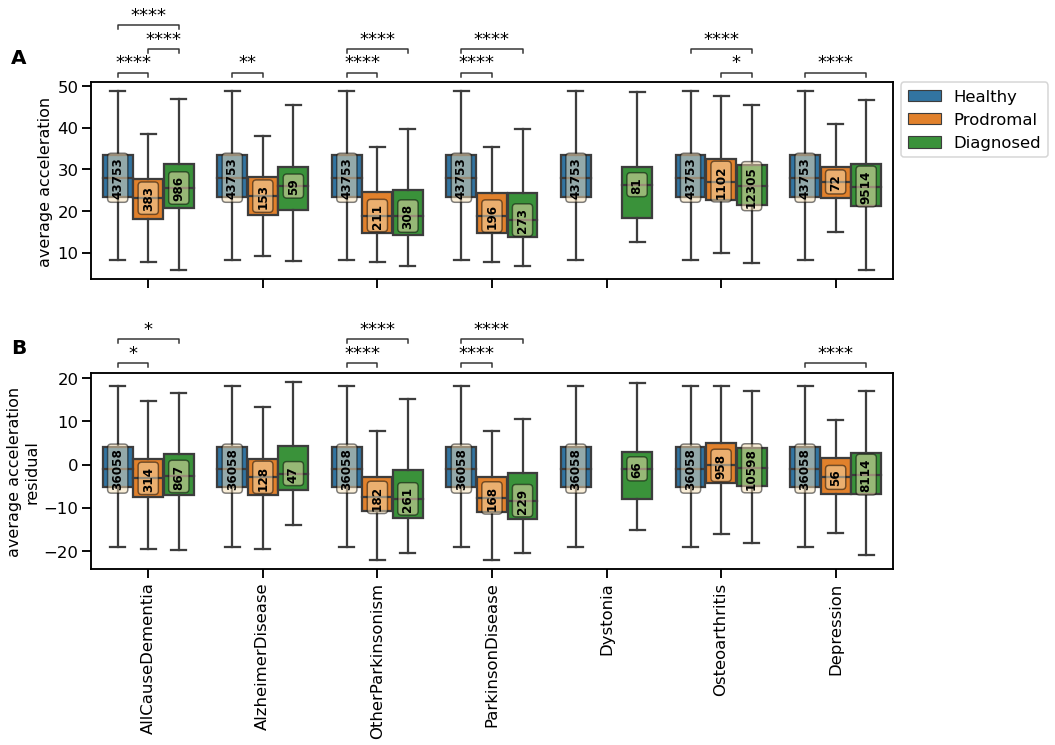

In [9]:
remove=20
ttests = []
labels = ['A','B']
fig, axes = plt.subplots(nrows=2,figsize=(15,11),sharex=True)
plots.plot_context()
for name,df,hc,y,(i,ax),label in zip(names[:2],dfs[:2],hcs[:2],ys[:2],enumerate(axes.flatten()),labels):
    subset = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression']
    data = df[df['diagnosis'].isin(subset)]
    data['Status'] = data['Status'].replace(['Diseased'],['Diagnosed'])
    # get all HC
    hc = hc.dropna(subset=[y],axis='rows',how='any')
    hc['Status'] = 'Healthy'
    # only use unique set of matched HC
    #hc = data[data['Status']=='Healthy']
    #hc = hc[~hc.index.duplicated(keep='first')]
    data=data[data['Status']!='Healthy']
    for diagnosis in subset:
        hc['diagnosis'] = diagnosis
        data = pd.concat([data,hc])
    thresh = 0.05/(len(subset)*3)
    annot = [[2e-6, "****"], [2e-5, "***"], [2e-4, "**"], [thresh, "*"], [1, "ns"]]
    box_pairs = []
    for diagnosis in subset:
        diag = data[data['diagnosis']==diagnosis]
        ttest = pd.DataFrame(index=pd.MultiIndex.from_product([['Healthy','Prodromal','Diagnosed'],['Healthy','Prodromal','Diagnosed']],
                                                              names = ['g1','g2']),columns=['t','p'])
        for i,g1 in enumerate(['Healthy','Prodromal','Diagnosed']):
            for j,g2 in enumerate(['Healthy','Prodromal','Diagnosed']):
                if j>i:
                    if g1=='Healthy':
                        t,p = stats.ttest_ind(hc[y],diag.loc[diag['Status']==g2,y])
                    elif g2=='Healthy':
                        t,p = stats.ttest_ind(diag.loc[diag['Status']==g1,y],hc[y])
                    else:
                        t,p = stats.ttest_ind(diag.loc[diag['Status']==g1,y],diag.loc[diag['Status']==g2,y])
                    ttest.loc[(g1,g2),'t'] = t
                    ttest.loc[(g1,g2),'p'] = p
        ttest = ttest.dropna(axis='rows',how='all')
        sign = ttest[ttest['p']<thresh]
        for key,row in sign.iterrows():
            box_pairs.append(((diagnosis,key[0]),(diagnosis,key[1])))
        if y=='average acceleration residual_bmi':
            ttests.append(ttest)   
    N_diagnosis = data.dropna(subset=[y]).groupby(['diagnosis','Status']).size()
    N_diagnosis = N_diagnosis.loc[(subset,['Healthy','Prodromal','Diagnosed'])]

    ax = sns.boxplot(y=y,hue='Status',x='diagnosis',data=data,hue_order=['Healthy','Prodromal','Diagnosed'],showfliers=False,
                    order=subset,ax=ax)
    
    ax, test_results = add_stat_annotation(ax, data=data, x='diagnosis', y=y, hue='Status',hue_order=['Healthy','Prodromal','Diagnosed'],
                                           order=subset,
                                       box_pairs=box_pairs,
                                       test='t-test_ind', text_format='star', loc='outside', verbose=2,comparisons_correction=None,
                                          pvalue_thresholds=annot)
    if label =='A':
        ax.set_ylabel('average acceleration')
    else:
        ax.set_ylabel('average acceleration\nresidual')
    ax.set_xlabel('')
    ax.set_xticklabels(['AllCauseDementia','AlzheimerDisease','OtherParkinsonism','ParkinsonDisease',
                        'Dystonia','Osteoarthritis','Depression'],rotation=90)
    if label=='A':
        ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);
    else:
        ax.legend([],[],frameon=False)
    plots.add_median_labels(ax,N_diagnosis,fmt="%d",remove=len(box_pairs))
    ax.text(-0.1, 1.1,label, transform=ax.transAxes,size=20, weight='bold')
plt.tight_layout()   
plt.savefig(f'{image_path}/diagsMatch_averageacc_boxplot_HCnoOsteoall_intercept.pdf',bbox_inches='tight',dpi=300)
plt.savefig(f'{image_path}/diagsMatch_averageacc_boxplot_HCnoOsteoall_intercept.png',bbox_inches='tight',dpi=300)

p-value annotation legend:
ns: 2.38e-03 < p <= 1.00e+00
*: 2.00e-04 < p <= 2.38e-03
**: 2.00e-05 < p <= 2.00e-04
***: 2.00e-06 < p <= 2.00e-05
****: p <= 2.00e-06

AllCauseParkinsonism_Healthy v.s. AllCauseParkinsonism_Prodromal: t-test independent samples, P_val=2.414e-27 stat=1.129e+01
ParkinsonDisease_Healthy v.s. ParkinsonDisease_Prodromal: t-test independent samples, P_val=1.938e-24 stat=1.062e+01
Osteoarthritis_Prodromal v.s. Osteoarthritis_Diagnosed: t-test independent samples, P_val=2.210e-03 stat=3.061e+00
AllCauseDementia_Healthy v.s. AllCauseDementia_Prodromal: t-test independent samples, P_val=8.982e-28 stat=1.111e+01
AllCauseDementia_Prodromal v.s. AllCauseDementia_Diagnosed: t-test independent samples, P_val=1.454e-10 stat=-6.460e+00
AlzheimerDisease_Healthy v.s. AlzheimerDisease_Prodromal: t-test independent samples, P_val=9.698e-04 stat=3.326e+00
AllCauseParkinsonism_Healthy v.s. AllCauseParkinsonism_Diagnosed: t-test independent samples, P_val=1.175e-26 stat=1.107e+01


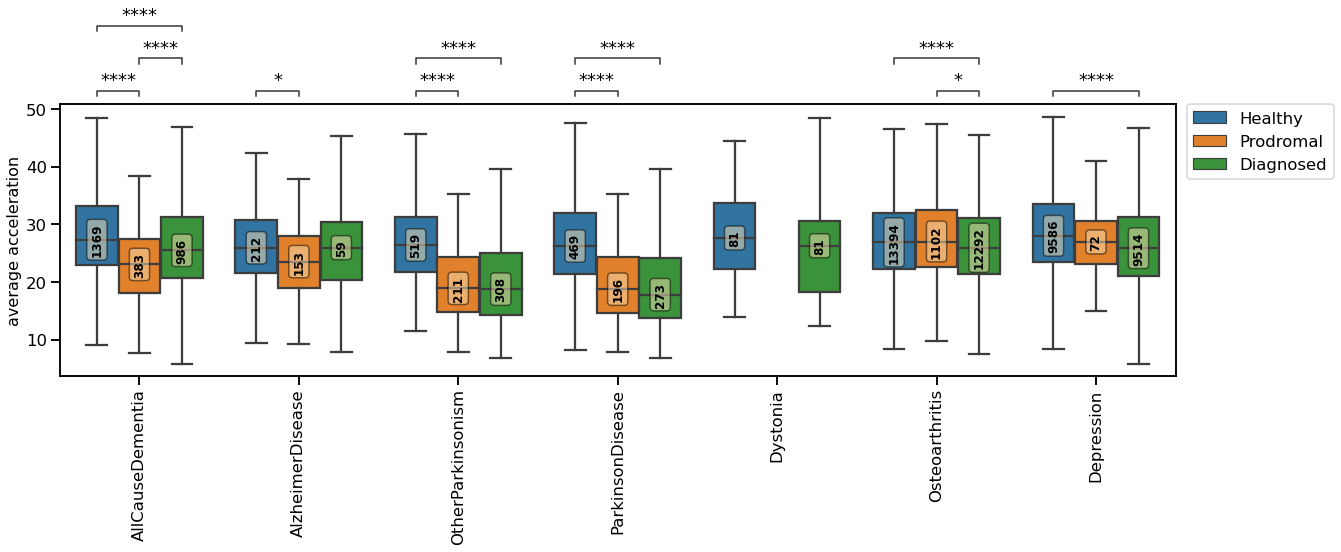

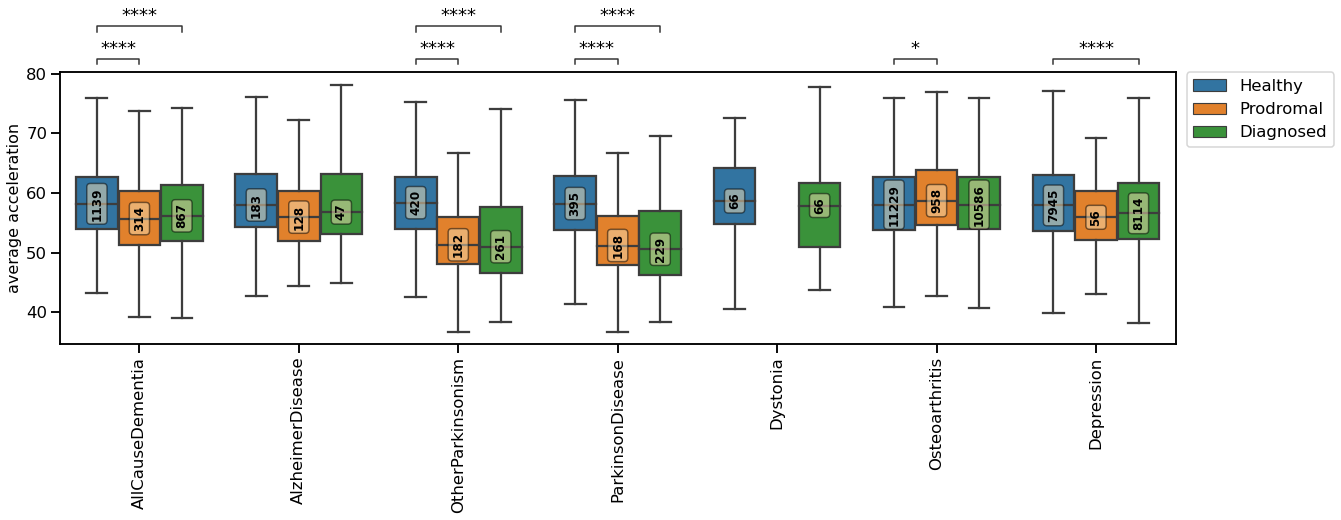

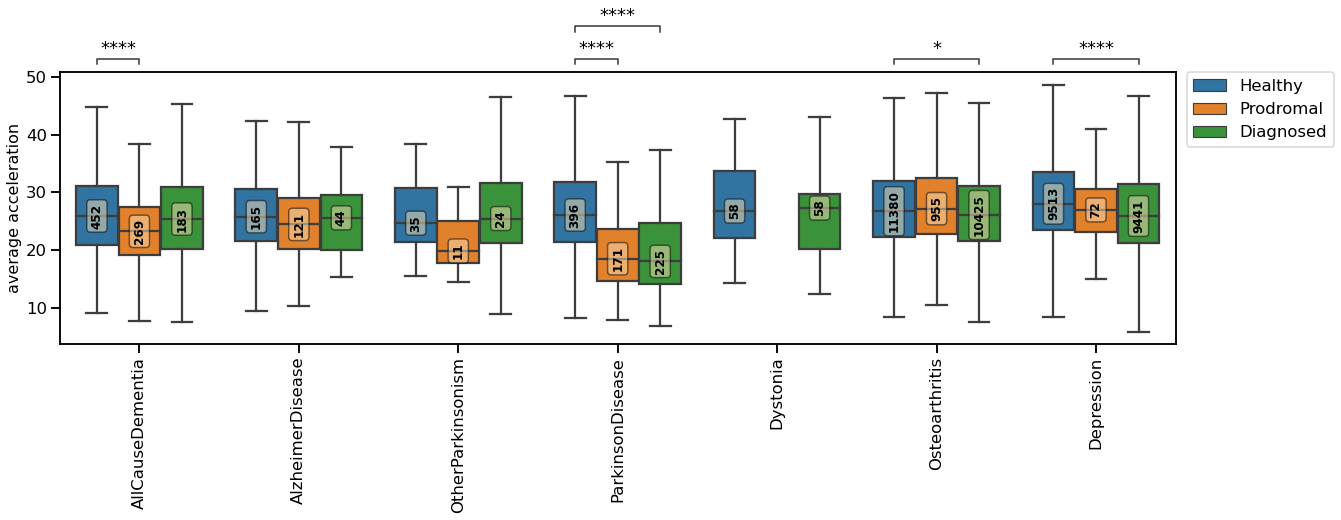

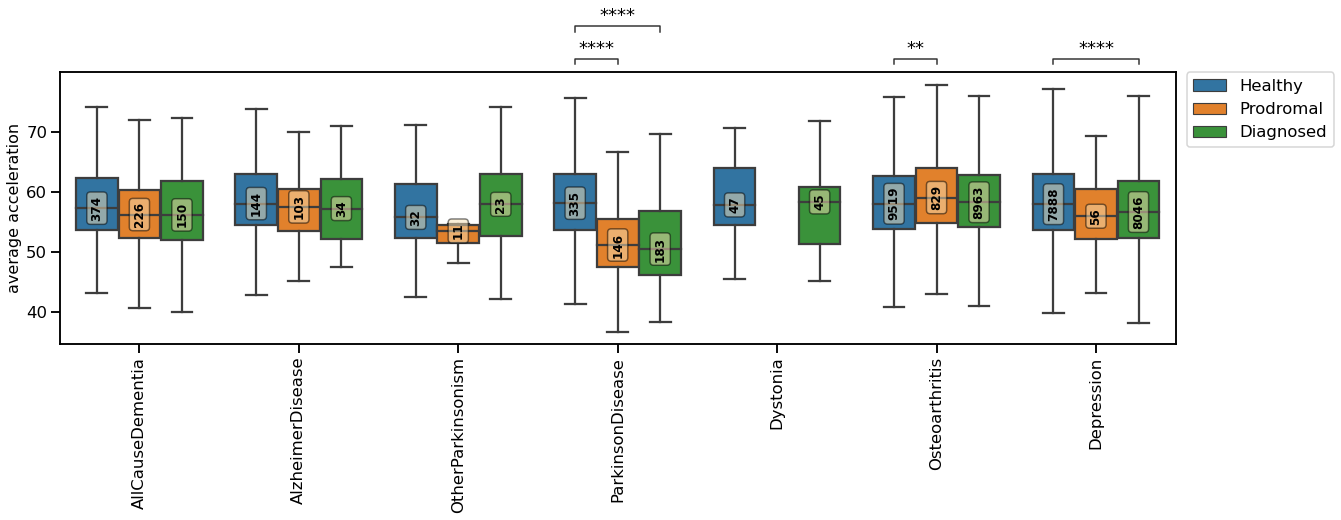

In [5]:
remove=20
ttests = []
for name,df,y in zip(names,dfs,ys):
    subset = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression']
    data = df[df['diagnosis'].isin(subset)]
    data['Status'] = data['Status'].replace(['Diseased'],['Diagnosed'])
    
    thresh = 0.05/(len(subset)*3)
    annot = [[2e-6, "****"], [2e-5, "***"], [2e-4, "**"], [thresh, "*"], [1, "ns"]]
    box_pairs = []
    for diagnosis in subset:
        diag = data[data['diagnosis']==diagnosis]
        ttest = pd.DataFrame(index=pd.MultiIndex.from_product([['Healthy','Prodromal','Diagnosed'],['Healthy','Prodromal','Diagnosed']],
                                                              names = ['g1','g2']),columns=['t','p'])
        for i,g1 in enumerate(['Healthy','Prodromal','Diagnosed']):
            for j,g2 in enumerate(['Healthy','Prodromal','Diagnosed']):
                if j>i:
                    t,p = stats.ttest_ind(diag.loc[diag['Status']==g1,y],diag.loc[diag['Status']==g2,y])
                    ttest.loc[(g1,g2),'t'] = t
                    ttest.loc[(g1,g2),'p'] = p
        ttest = ttest.dropna(axis='rows',how='all')
        sign = ttest[ttest['p']<thresh]
        for key,row in sign.iterrows():
            box_pairs.append(((diagnosis,key[0]),(diagnosis,key[1])))
        if y=='average acceleration residual_bmi':
            ttests.append(ttest)   
    N_diagnosis = data.dropna(subset=[y]).groupby(['diagnosis','Status']).size()
    N_diagnosis = N_diagnosis.loc[(subset,['Healthy','Prodromal','Diagnosed'])]
    fig = plt.figure(figsize=(20,5))
    plots.plot_context()
    ax = sns.boxplot(y=y,hue='Status',x='diagnosis',data=data,hue_order=['Healthy','Prodromal','Diagnosed'],showfliers=False,
                    order=subset)
    ax, test_results = add_stat_annotation(ax, data=data, x='diagnosis', y=y, hue='Status',hue_order=['Healthy','Prodromal','Diagnosed'],
                                           order=subset,
                                       box_pairs=box_pairs,
                                       test='t-test_ind', text_format='star', loc='outside', verbose=2,comparisons_correction=None,
                                          pvalue_thresholds=annot)
    ax.set_ylabel('average acceleration')
    ax.set_xlabel('')
    ax.set_xticklabels(['AllCauseDementia','AlzheimerDisease','OtherParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression'],rotation=90)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);
    plots.add_median_labels(ax,N_diagnosis,fmt="%d",remove=len(box_pairs))
    
    plt.savefig(f'{image_path}/diagsMatch_averageacc_boxplot_{name}_HCnoOsteo.pdf',bbox_inches='tight',dpi=300)
    plt.savefig(f'{image_path}/diagsMatch_averageacc_boxplot_{name}_HCnoOsteo.png',bbox_inches='tight',dpi=300)

In [52]:
names

['all', 'all_BMI', 'NoDepressedNoPD', 'NoDepressedNoPD_BMI']

<ipython-input-11-0d5df3db6e24>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Status'] = data['Status'].replace(['Diseased'],['Diagnosed'])


p-value annotation legend:
ns: 2.38e-03 < p <= 1.00e+00
*: 2.00e-04 < p <= 2.38e-03
**: 2.00e-05 < p <= 2.00e-04
***: 2.00e-06 < p <= 2.00e-05
****: p <= 2.00e-06

AllCauseParkinsonism_Healthy v.s. AllCauseParkinsonism_Prodromal: t-test independent samples, P_val=1.641e-16 stat=8.249e+00
ParkinsonDisease_Healthy v.s. ParkinsonDisease_Prodromal: t-test independent samples, P_val=1.189e-15 stat=8.009e+00
Osteoarthritis_Prodromal v.s. Osteoarthritis_Diagnosed: t-test independent samples, P_val=2.068e-03 stat=3.081e+00
AllCauseDementia_Healthy v.s. AllCauseDementia_Prodromal: t-test independent samples, P_val=2.172e-12 stat=7.025e+00
AllCauseDementia_Prodromal v.s. AllCauseDementia_Diagnosed: t-test independent samples, P_val=1.454e-10 stat=-6.460e+00
AlzheimerDisease_Healthy v.s. AlzheimerDisease_Prodromal: t-test independent samples, P_val=1.296e-04 stat=3.828e+00
AllCauseParkinsonism_Healthy v.s. AllCauseParkinsonism_Diagnosed: t-test independent samples, P_val=1.794e-20 stat=9.279e+00


<ipython-input-11-0d5df3db6e24>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Status'] = data['Status'].replace(['Diseased'],['Diagnosed'])


p-value annotation legend:
ns: 2.38e-03 < p <= 1.00e+00
*: 2.00e-04 < p <= 2.38e-03
**: 2.00e-05 < p <= 2.00e-04
***: 2.00e-06 < p <= 2.00e-05
****: p <= 2.00e-06

ParkinsonDisease_Healthy v.s. ParkinsonDisease_Prodromal: t-test independent samples, P_val=1.034e-14 stat=7.738e+00
AllCauseDementia_Healthy v.s. AllCauseDementia_Prodromal: t-test independent samples, P_val=1.046e-07 stat=5.319e+00
ParkinsonDisease_Healthy v.s. ParkinsonDisease_Diagnosed: t-test independent samples, P_val=7.012e-17 stat=8.350e+00
Osteoarthritis_Healthy v.s. Osteoarthritis_Diagnosed: t-test independent samples, P_val=1.167e-34 stat=1.229e+01
Depression_Healthy v.s. Depression_Diagnosed: t-test independent samples, P_val=4.320e-40 stat=1.326e+01
p-value annotation legend:
ns: 2.38e-03 < p <= 1.00e+00
*: 2.00e-04 < p <= 2.38e-03
**: 2.00e-05 < p <= 2.00e-04
***: 2.00e-06 < p <= 2.00e-05
****: p <= 2.00e-06

ParkinsonDisease_Healthy v.s. ParkinsonDisease_Prodromal: t-test independent samples, P_val=1.303e-08 s

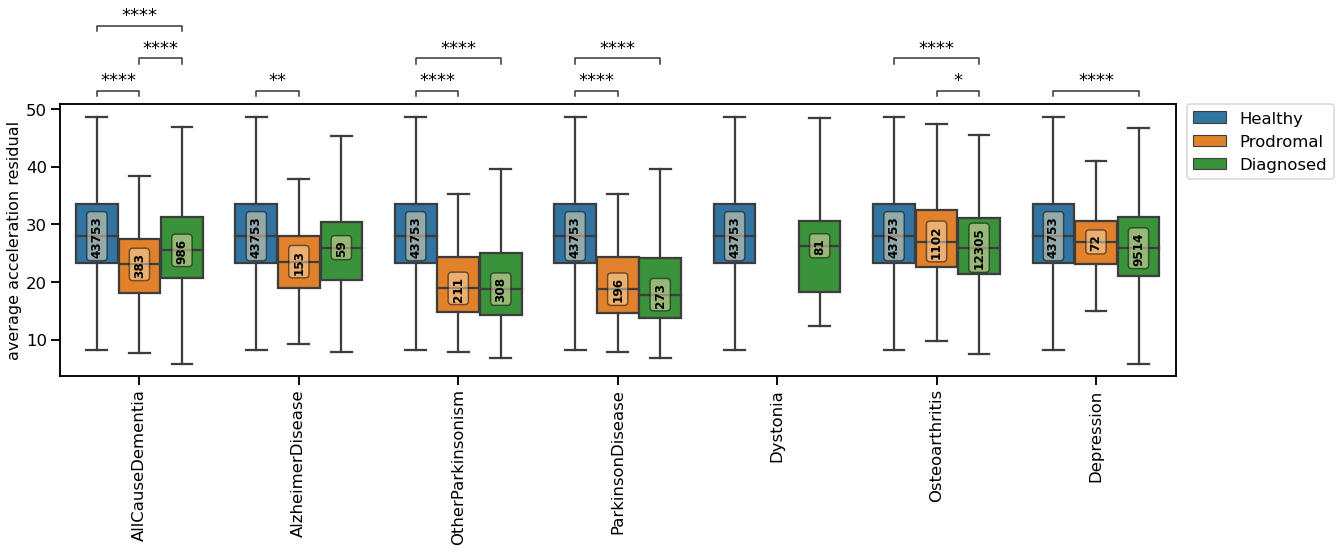

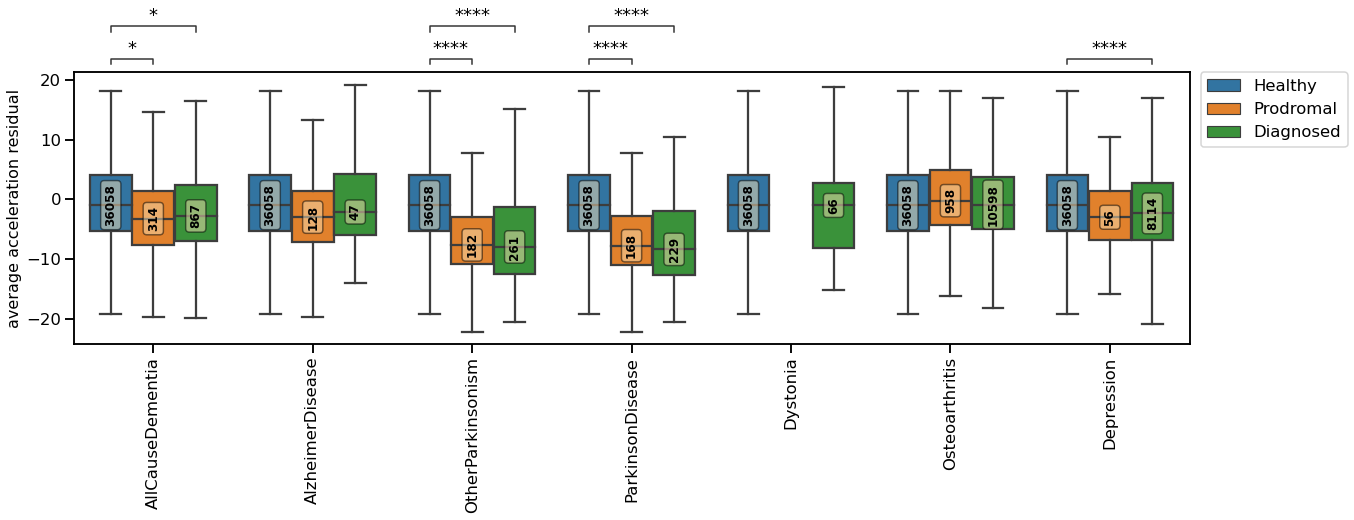

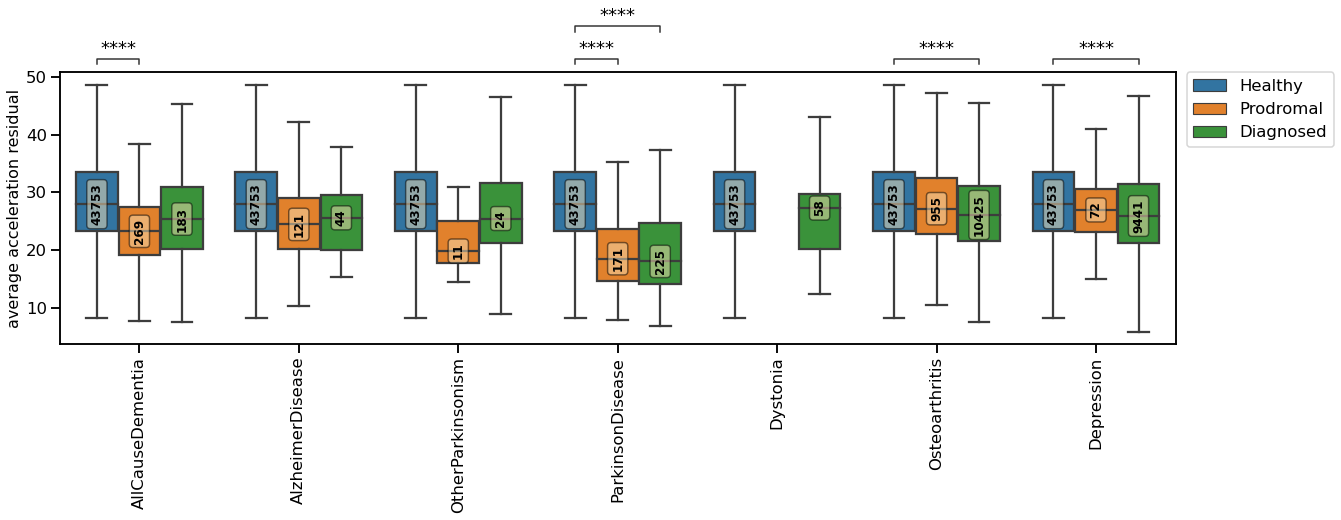

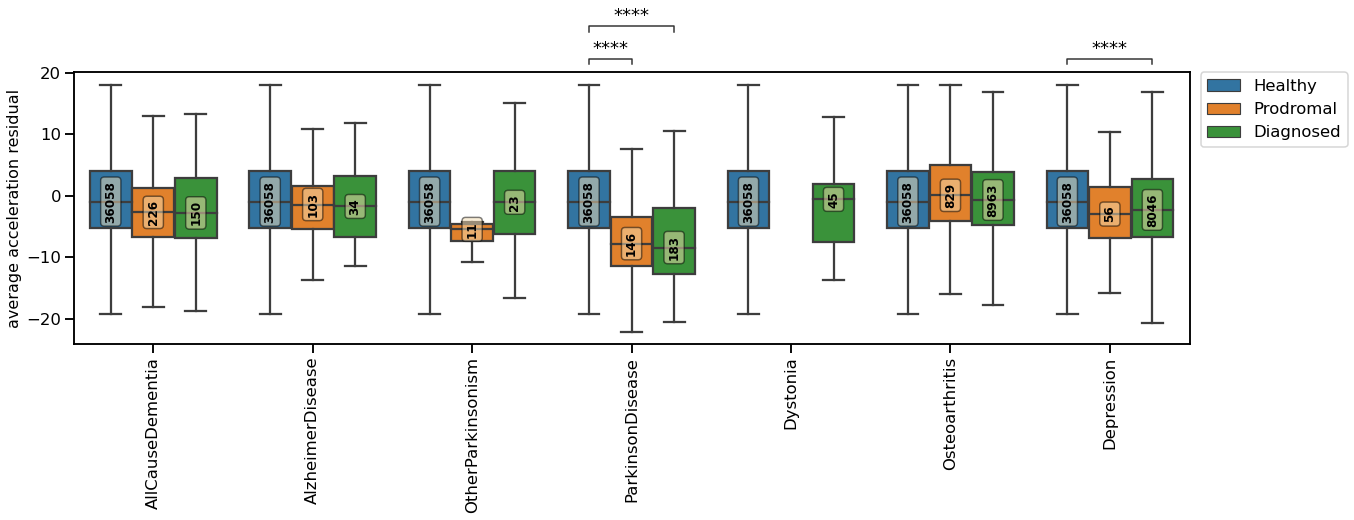

In [11]:
remove=20
ttests = []
for name,df,hc,y in zip(names,dfs,hcs,ys):
    subset = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression']
    data = df[df['diagnosis'].isin(subset)]
    data['Status'] = data['Status'].replace(['Diseased'],['Diagnosed'])
    # get all HC
    hc = hc.dropna(subset=[y],axis='rows',how='any')
    hc['Status'] = 'Healthy'
    # only use unique set of matched HC
    #hc = data[data['Status']=='Healthy']
    #hc = hc[~hc.index.duplicated(keep='first')]
    data=data[data['Status']!='Healthy']
    for diagnosis in subset:
        hc['diagnosis'] = diagnosis
        data = pd.concat([data,hc])
    thresh = 0.05/(len(subset)*3)
    annot = [[2e-6, "****"], [2e-5, "***"], [2e-4, "**"], [thresh, "*"], [1, "ns"]]
    box_pairs = []
    for diagnosis in subset:
        diag = data[data['diagnosis']==diagnosis]
        ttest = pd.DataFrame(index=pd.MultiIndex.from_product([['Healthy','Prodromal','Diagnosed'],['Healthy','Prodromal','Diagnosed']],
                                                              names = ['g1','g2']),columns=['t','p'])
        for i,g1 in enumerate(['Healthy','Prodromal','Diagnosed']):
            for j,g2 in enumerate(['Healthy','Prodromal','Diagnosed']):
                if j>i:
                    if g1=='Healthy':
                        t,p = stats.ttest_ind(hc[y],diag.loc[diag['Status']==g2,y])
                    elif g2=='Healthy':
                        t,p = stats.ttest_ind(diag.loc[diag['Status']==g1,y],hc[y])
                    else:
                        t,p = stats.ttest_ind(diag.loc[diag['Status']==g1,y],diag.loc[diag['Status']==g2,y])
                    ttest.loc[(g1,g2),'t'] = t
                    ttest.loc[(g1,g2),'p'] = p
        ttest = ttest.dropna(axis='rows',how='all')
        sign = ttest[ttest['p']<thresh]
        for key,row in sign.iterrows():
            box_pairs.append(((diagnosis,key[0]),(diagnosis,key[1])))
        if y=='average acceleration residual_bmi':
            ttests.append(ttest)   
    N_diagnosis = data.dropna(subset=[y]).groupby(['diagnosis','Status']).size()
    N_diagnosis = N_diagnosis.loc[(subset,['Healthy','Prodromal','Diagnosed'])]
    fig = plt.figure(figsize=(20,5))
    plots.plot_context()
    ax = sns.boxplot(y=y,hue='Status',x='diagnosis',data=data,hue_order=['Healthy','Prodromal','Diagnosed'],showfliers=False,
                    order=subset)
    ax, test_results = add_stat_annotation(ax, data=data, x='diagnosis', y=y, hue='Status',hue_order=['Healthy','Prodromal','Diagnosed'],
                                           order=subset,
                                       box_pairs=box_pairs,
                                       test='t-test_ind', text_format='star', loc='outside', verbose=2,comparisons_correction=None,
                                          pvalue_thresholds=annot)
    ax.set_ylabel('average acceleration residual')
    ax.set_xlabel('')
    ax.set_xticklabels(['AllCauseDementia','AlzheimerDisease','OtherParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression'],rotation=90)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);
    plots.add_median_labels(ax,N_diagnosis,fmt="%d",remove=len(box_pairs))
    
    if name == names[-1]:
        plt.savefig(f'{image_path}/diagsMatch_averageacc_boxplot_{name}_HCnoOsteoall_intercept.pdf',bbox_inches='tight',dpi=300)
        plt.savefig(f'{image_path}/diagsMatch_averageacc_boxplot_{name}_HCnoOsteoall_intercept.png',bbox_inches='tight',dpi=300)